# Lending Club - Case Study

## Prepare Data
### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Reading the input Data (CSV File)

In [2]:
loan = pd.read_csv('loan.csv', header=0)

loan.shape[0]

39717

### Initial Analysis

- The Data contains 38717 Records and 111 rows. 
- The Data corresponds to a Loan Data set, which has loans catered to different purposes.
- The Data has few demographic information which can be made use of.

In [3]:
# We're re-using this function again at the end of data cleaning to verify if we have all good data to move ahead. 

def print_data_quality(quality_index = 25):
    loan_columns = pd.DataFrame(loan.columns.set_names('Columns'))
    loan_columns['PercentNA'] = loan_columns.Columns.apply(lambda x: round(100* (loan[x].isna() | loan[x].isnull()).sum()/loan.shape[0], 2))
    print("{}% of data has >25% of Null or NA values".format(round(loan_columns[loan_columns.PercentNA > quality_index].count()*100/loan_columns.count(), 2).Columns))

In [4]:
print_data_quality(25)

52.25% of data has >25% of Null or NA values


> Almost 52% of the columns have more than 25% of empty data.

#### Analysis of Columns

- The column **id**, **member_id** are person identity columns. Since, this is not specific to loan requesters. 
    - *TODO:* we can remove them. 

- The requested Loan Amount is listed in the column **loan_amnt**
- The Loan amount suggested by the Lending Club at the time of loan issuance is listed in the column **funded_amnt**
- The Loan approved by the investor authority (final loan amount is mentioned in the **funded_amnt_inv**)

- The column **term** represents the tenure of the Loan. We have only 2 values here 36 months and 60 months.
    - *TODO:* clean the data to make it an integer.

- The loan issue date is represented in the column **issue_d**. It has missing day column.
    - *TODO:* Convert this to a DateTime and extract the year and month details.

- The interest rate of the loan approved is mentioned in the **int_rate** column.
    - *TODO:* Clean the data by removing the % so as we can use it for bucketted analysis.

- The **grade** and **sub-grade** are the internal categories assigned by the Lending Club. May be used to differentiate certain entries.

- The column **emp_title** has incomplete information. Employee Title doesn't have any say on the Defaulted loan.. as it is just a job title or name.
    - *TODO:* This column can be removed.

- The column **emp_length** has inadequate data.
    - *TODO:* Try filling in the missing values.
    

- The column **home_ownership** variable indirectly describes the assert class of the loan taker. So, it can be analyzed to identify a correlation across the defaulters.

- The column **annual_inc** has annual incomes and can be used for analysis to identify how it is impacting the defaulters.


- The column **verification_status** has background verification status; an important attribute which can identify the defaulters.

- The column **issue_d** is the loan issued date. We can extract the information of month and year from it.

- The column **loan_status** signifies if the loan is *fully paid/current/charged off*.
    - *TODO:* It may not make any sense to analyze the on-going loans (ie., in current status) as the data will be uncertain (an ongoing loan can be Fully Paid or Charged Off and none of these cases can be known in advance)...


- The column **url**, **desc** are having clearical information and not a driving factor for the Defaulters.
    - *TODO:* Remove these columns from the dataset

- The column **title** has incomplete information. Initial glance at the data, it seems to be a title of an email for loan application. Title doesn't have any say on the Defaulted loan.. as it is just another textual information.
    - *TODO:* This column can be removed.

- The column **purpose** is a categorical variable and can be useful for our analysis.

- The column **addr_state** may be used to extract the impact demographics over the possibility of defaulting.

- The column **zip_code** has masked zip codes and may not provide any granular information on demographics. This can be set aside as we already have addr_state under analysis.

- The column **dti** - Debit to Income, could be an important factor as it determines the economic potential of the member.

- The column **pub_rec** represents number of public derogatory records (previous instances of bad financials with other institutions)... could be a factor that can emphasize a defaulting can happen again with this entry.

- Following set of columns are pointing to the current loan details and may not be useful to analyze on them.
    - delinq_2yrs
    - earliest_cr_line
    - inq_last_6mths
    - mths_since_last_delinq
    - mths_since_last_record
    - open_acc
    - out_prncp
    - out_prncp_inv
    - total_pymnt
    - total_pymnt_inv
    - total_rec_prncp
    - total_rec_int
    - recoveries
    - collection_recovery_fee
    - last_pymnt_d
    - last_pymnt_amnt
    - next_pymnt_d
    - last_credit_pull_d
    - collections_12_mths_ex_med
    - mths_since_last_major_derog

- The column **pub_rec_bankruptcies** may help us identify the previous bankruptcies.
- The column **total_acc** may help us on identifying the Defaulters as it has the info on other loans taken by him and are active.


- Furthermore, there are many columns which have only 1 value. These columns doesn't help us on the analysis as the values are constant for the entire data set.
    - *TODO:* Drop these columns

### Data Cleaning

#### Drop Columns

##### Drop unwanted columns

In [5]:
loan = loan.drop(["id", "member_id", "emp_title", "url", "desc", "title", "zip_code", "delinq_2yrs", "earliest_cr_line", "mths_since_last_delinq", "mths_since_last_record", "open_acc", "revol_bal", "revol_util", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "recoveries", "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d", "collections_12_mths_ex_med", "chargeoff_within_12_mths"], axis=1)

##### Drop columns with only 1 Unique Value

In [6]:
### Columns that have only 1 value in the dataset. They doesn't help us in the analysis and can be ignored.
#for col in loan.columns:
#    if(len(loan[col].unique()) == 1) :
#        print(col)

columns_to_work = loan.columns[loan.apply(lambda x: len(x.unique()) > 1)].tolist()
loan = loan.loc[:, columns_to_work]
loan.info()
loan.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loan_amnt             39717 non-null  int64  
 1   funded_amnt           39717 non-null  int64  
 2   funded_amnt_inv       39717 non-null  float64
 3   term                  39717 non-null  object 
 4   int_rate              39717 non-null  object 
 5   installment           39717 non-null  float64
 6   grade                 39717 non-null  object 
 7   sub_grade             39717 non-null  object 
 8   emp_length            38642 non-null  object 
 9   home_ownership        39717 non-null  object 
 10  annual_inc            39717 non-null  float64
 11  verification_status   39717 non-null  object 
 12  issue_d               39717 non-null  object 
 13  loan_status           39717 non-null  object 
 14  purpose               39717 non-null  object 
 15  addr_state         

(39717, 23)

#### Drop missing data

In [7]:
loan = loan[loan.funded_amnt_inv > 0]
loan.shape

(39588, 23)

### Fill-in Missing Data

##### Find any missing data in the columns

In [8]:
loan.columns[loan.isna().any()].append(loan.columns[loan.isnull().any()]).unique()

Index(['emp_length', 'pub_rec_bankruptcies', 'tax_liens'], dtype='object')

#### Fill-in the emp_length column

In [9]:
loan[loan.emp_length.isna()].shape

(1075, 23)

- we have ~ 1075 Rows of data with no emp_length. this is a very small number when compared to 39717.
- We can fill the missing information with a value with occurs the most (more frequent data in the column).

In [10]:
# Calculate the mean emp_length

mode_of_emp_length = loan[-loan.emp_length.isna()].emp_length.apply(lambda x: x).mode()

print('Mode of emp_length: '+ mode_of_emp_length[0])

loan.emp_length.fillna(mode_of_emp_length[0], inplace=True)


Mode of emp_length: 10+ years


In [11]:
# Clean the column emp_length

def convert_emp(x):
    if(x=='< 1 year'):
        return 0
    elif(x=='1 year'):
        return 1
    elif(x=='10+ years'):
        return 10
    elif(type(x) == str):
        return x.replace(' years', '')
    else:
        return np.nan

loan['emp_length'] = loan.emp_length.apply(lambda x: int(convert_emp(x)))

#### Analyze the tax_liens column

In [12]:
#### Check the tax_liens column
loan.tax_liens.unique()

array([ 0., nan])

- The Tax Liens has only 2 values 0.0 and Nan. Filling in doesn't make sense. We can discard this column as well.

In [13]:
loan = loan.drop(["tax_liens"], axis=1)

#### Analyze the pub_rec_bankruptcies column

In [14]:
#### Check the pub_rec_bankruptcies column
loan.pub_rec_bankruptcies.value_counts()

0.0    37216
1.0     1669
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [15]:
loan = loan.drop(["pub_rec_bankruptcies"], axis=1)

In [16]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39588 entries, 0 to 39716
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_amnt            39588 non-null  int64  
 1   funded_amnt          39588 non-null  int64  
 2   funded_amnt_inv      39588 non-null  float64
 3   term                 39588 non-null  object 
 4   int_rate             39588 non-null  object 
 5   installment          39588 non-null  float64
 6   grade                39588 non-null  object 
 7   sub_grade            39588 non-null  object 
 8   emp_length           39588 non-null  int64  
 9   home_ownership       39588 non-null  object 
 10  annual_inc           39588 non-null  float64
 11  verification_status  39588 non-null  object 
 12  issue_d              39588 non-null  object 
 13  loan_status          39588 non-null  object 
 14  purpose              39588 non-null  object 
 15  addr_state           39588 non-null 

In [17]:
#### Check for Data Quality Now...
print_data_quality(1)

0.0% of data has >25% of Null or NA values


### Data Conversions

### Convert the Date Columns to Datetime...

In [18]:
loan.issue_d = pd.to_datetime(loan.issue_d, format='%b-%y')

#### Extract the Month and Year data from the Issue date Columns

In [19]:
# Add columns for Issue year and month for analysis
loan['issue_year'] = pd.DatetimeIndex(loan.issue_d).year
loan['issue_month'] = pd.DatetimeIndex(loan.issue_d).month

### Convert int_rate to numeric

In [20]:
# Convert the Interest Rate Column
loan['int_rate'] = loan.int_rate.apply(lambda x: float(x.replace('%', '')))

### Convert term data to number

In [21]:
# Convert term data to numeric
loan['term'] = loan.term.apply(lambda x: int(x.replace(' months','')))

### Rename Columns for Better Readability

In [22]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39588 entries, 0 to 39716
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loan_amnt            39588 non-null  int64         
 1   funded_amnt          39588 non-null  int64         
 2   funded_amnt_inv      39588 non-null  float64       
 3   term                 39588 non-null  int64         
 4   int_rate             39588 non-null  float64       
 5   installment          39588 non-null  float64       
 6   grade                39588 non-null  object        
 7   sub_grade            39588 non-null  object        
 8   emp_length           39588 non-null  int64         
 9   home_ownership       39588 non-null  object        
 10  annual_inc           39588 non-null  float64       
 11  verification_status  39588 non-null  object        
 12  issue_d              39588 non-null  datetime64[ns]
 13  loan_status          39588 non-

In [23]:
loan.rename(columns={'loan_amnt' : 'loan_amount', 'funded_amnt': 'funded_amount', 'funded_amnt_inv': 'funded_amount_investor', 'int_rate': 'interest_rate'}, inplace=True)
loan.rename(columns={'issue_d' : 'issue_date', 'annual_inc': 'annual_income', 'total_rec_late_fee' :'total_received_late_fee', 'pub_rec' : 'public_derogatory_records'}, inplace=True)

loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39588 entries, 0 to 39716
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   loan_amount                39588 non-null  int64         
 1   funded_amount              39588 non-null  int64         
 2   funded_amount_investor     39588 non-null  float64       
 3   term                       39588 non-null  int64         
 4   interest_rate              39588 non-null  float64       
 5   installment                39588 non-null  float64       
 6   grade                      39588 non-null  object        
 7   sub_grade                  39588 non-null  object        
 8   emp_length                 39588 non-null  int64         
 9   home_ownership             39588 non-null  object        
 10  annual_income              39588 non-null  float64       
 11  verification_status        39588 non-null  object        
 12  issu

## Exploratory Data Analysis

### Univariate & Bivariate Analysis

#### Identify the Data

In [24]:
#Continuous Columns in the data
continuous_columns = ['funded_amount_investor', 'interest_rate', 'annual_income', 'installment', 'emp_length', 'inq_last_6mths', 'dti', 'public_derogatory_records', 'total_received_late_fee']
categorical_columns = ['term', 'grade', 'sub_grade', 'verification_status', 'home_ownership', 'purpose', 'addr_state', 'issue_year', 'issue_month']

loan.loc[:,continuous_columns].describe()

,funded_amount_investor,interest_rate,annual_income,installment,emp_length,inq_last_6mths,dti,public_derogatory_records,total_received_late_fee
count,39588.000000,39588.000000,3.958800e+04,39588.000000,39588.000000,39588.000000,39588.000000,39588.000000,39588.000000
mean,10431.329612,12.025695,6.900537e+04,325.020770,5.114328,0.868117,13.321370,0.055067,1.355137
std,7115.262677,3.728447,6.383326e+04,209.006628,3.606649,1.068858,6.676537,0.237234,7.261100
min,0.000121,5.420000,4.000000e+03,15.690000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5000.000000,9.250000,4.050000e+04,167.087500,2.000000,0.000000,8.190000,0.000000,0.000000
50%,8996.421297,11.860000,5.900000e+04,280.970000,5.000000,1.000000,13.410000,0.000000,0.000000
75%,14400.000000,14.590000,8.250000e+04,431.370000,10.000000,1.000000,18.600000,0.000000,0.000000
max,35000.000000,24.590000,6.000000e+06,1305.190000,10.000000,8.000000,29.990000,4.000000,180.200000


In [25]:
loan.loc[:,categorical_columns].describe()

,term,issue_year,issue_month
count,39588.000000,39588.000000,39588.000000
mean,42.438921,2010.336516,7.173689
std,10.633779,0.868715,3.401278
min,36.000000,2007.000000,1.000000
25%,36.000000,2010.000000,4.000000
50%,36.000000,2011.000000,7.000000
75%,60.000000,2011.000000,10.000000
max,60.000000,2011.000000,12.000000


#### Filter the relavent data to our analysis

In [26]:
# Our analysis is not on current loans. Hence, ignoring it.
#
loan = loan[loan.loan_status != 'Current']
loan.shape

charged_off_loans = loan[loan.loan_status == 'Charged Off']
fully_paid_loans = loan[loan.loan_status == 'Fully Paid']


#### Identify Outliers in Annual Income Column

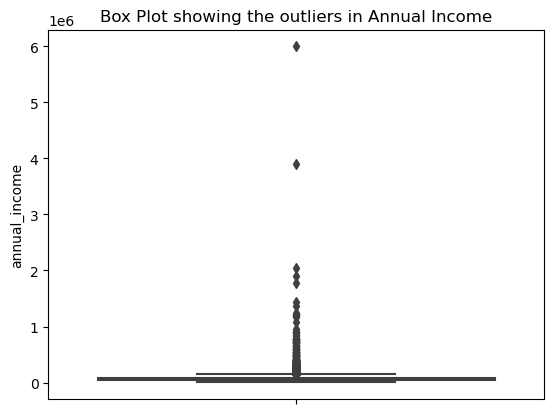

In [27]:
# The data shows that the annual_income series has a very big range of data and may contain outliers.
sns.boxplot(data=loan, y='annual_income')
plt.title('Box Plot showing the outliers in Annual Income')
plt.show()

- annual_income column has outliers. We can limit the annual_income to < 150000

In [28]:
# Filter out the outliers of data.
loan = loan[loan.annual_income<150000]

### Analyzing the Data - Univariate Analysis

#### Analysing the Frequency of the funded_amount_investor values

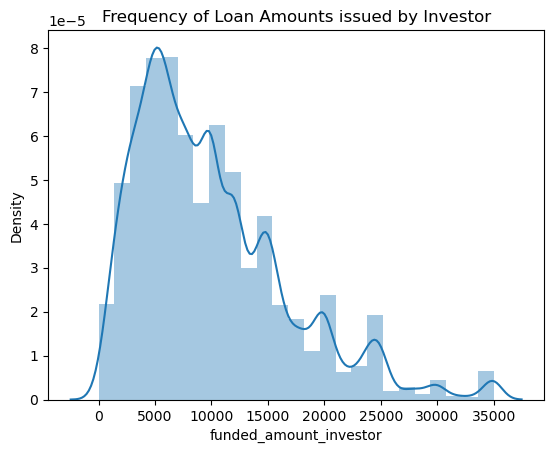

In [29]:
# Analysing the Funded Amount Investor data
plt.title('Frequency of Loan Amounts issued by Investor')
plt.xlabel('Amount funded by the Investor')
#sns.histplot(data=loan, x='funded_amount_investor', bins=25)
sns.distplot(loan.funded_amount_investor, bins=25)
plt.show()

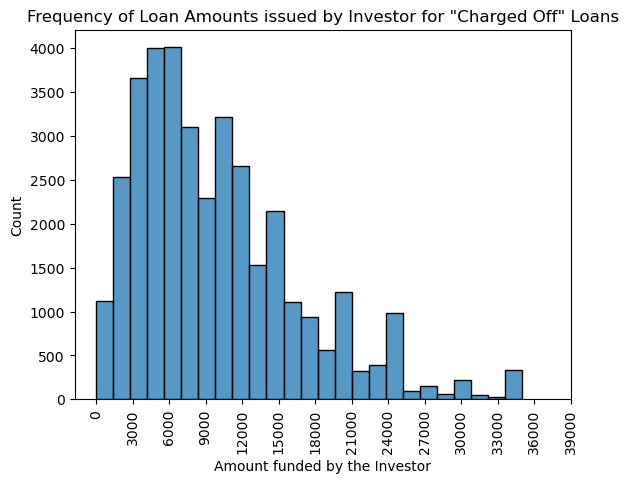

<Figure size 1200x800 with 0 Axes>

In [30]:
# Analysing the Funded Amount Investor data
plt.title('Frequency of Loan Amounts issued by Investor for "Charged Off" Loans')
plt.xlabel('Amount funded by the Investor')
sns.histplot(data=loan, x='funded_amount_investor', bins=25)
plt.xticks(np.arange(0, 40000, 3000), rotation=90)
plt.figure(figsize=(12,8))
plt.show()

> Most of the loans funded are with an investor fund between <10000. And loans funded between 3000-6000 have higher chances of Charged Off

#### Analysing the Frequency of the purpose values

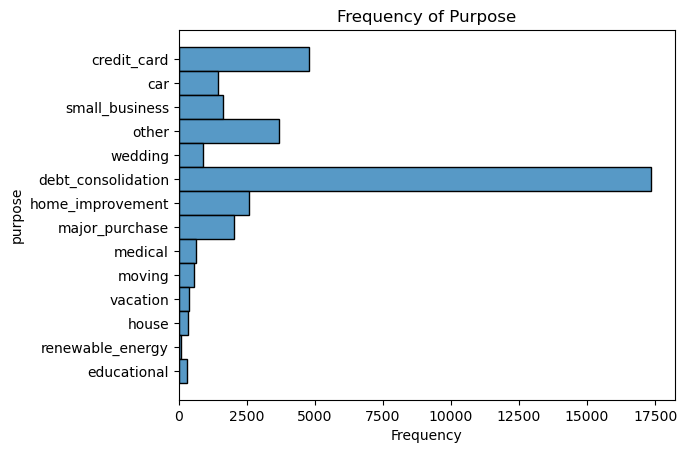

In [31]:
sns.histplot(data=loan, y='purpose')
plt.title('Frequency of Purpose')
plt.xlabel('Frequency')
plt.show()

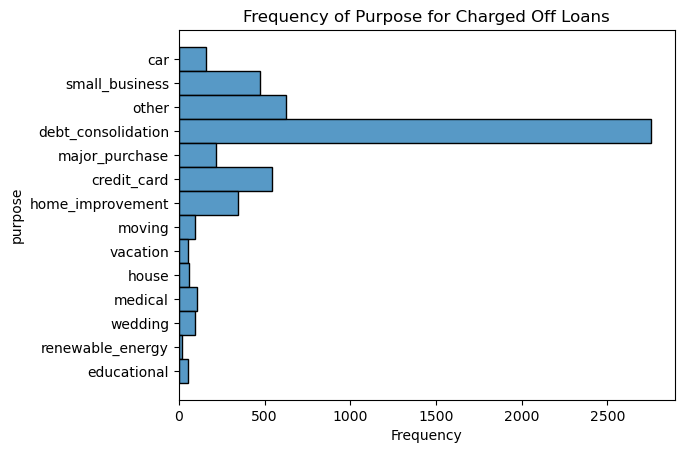

In [32]:
sns.histplot(data=charged_off_loans, y='purpose')
plt.title('Frequency of Purpose for Charged Off Loans')
plt.xlabel('Frequency')
plt.show()

> Loans against the purpose Debt_Consolidation top the graph. 

> As the loans issued for the purpose of Debt_Consolidation are top, the Charged Off% is also high. 
> Inorder to extract more accurate metric, we can proportionate the Charged Off % of loan_statuses for each of the purpose.

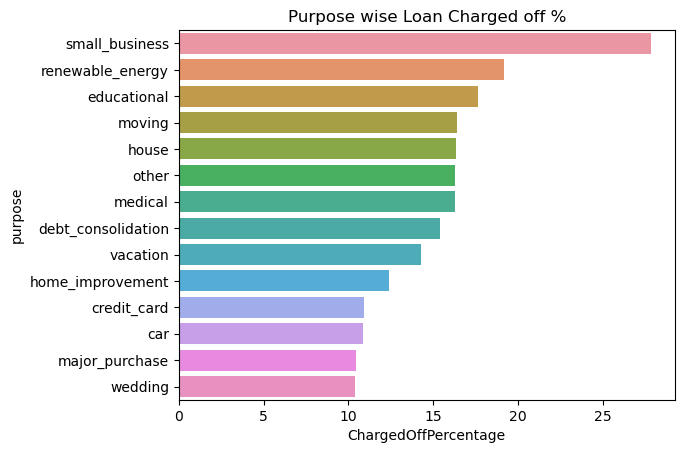

In [33]:
purpose_wise_loan_status = loan.pivot_table(columns='loan_status', index='purpose', values='funded_amount', aggfunc='count', fill_value=0)
purpose_wise_loan_status['ChargedOffPercentage'] = purpose_wise_loan_status['Charged Off'] *100 /(purpose_wise_loan_status['Charged Off'] + purpose_wise_loan_status['Fully Paid'])

purpose_wise_loan_status = purpose_wise_loan_status.reset_index()
purpose_wise_loan_status = purpose_wise_loan_status.sort_values('ChargedOffPercentage', ascending=False)
#plt.figure(figsize=(10,15))
plt.title('Purpose wise Loan Charged off %')
sns.barplot(data=purpose_wise_loan_status, x='ChargedOffPercentage', y='purpose')
plt.show()

> We observe that the more % of loans are charged off when taken for the purpose 'small_business'

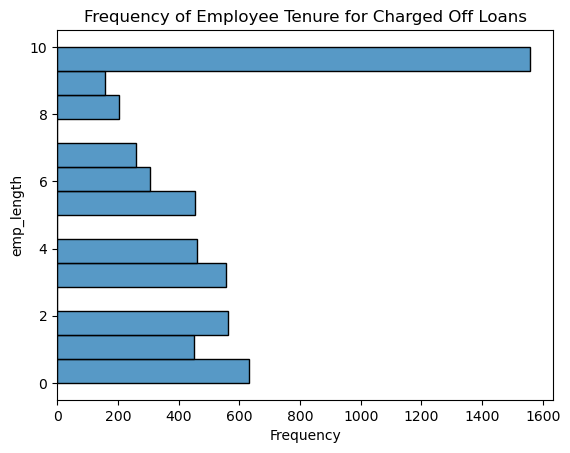

In [34]:
sns.histplot(data=charged_off_loans, y='emp_length')
plt.title('Frequency of Employee Tenure for Charged Off Loans')
plt.xlabel('Frequency')
plt.show()

> We see the loans issued to People with employment 10 or more years are more likely to be Charged Off.

#### Analysing the Frequency of the verification_status values

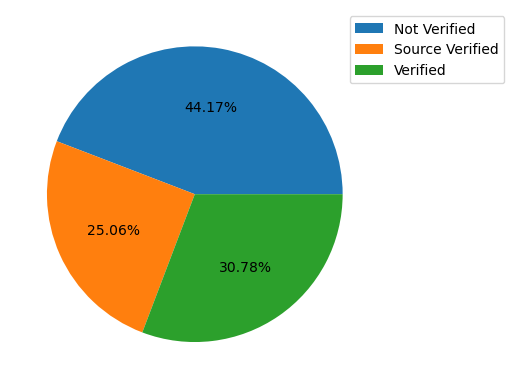

In [35]:
# Let's try analyzing the outliers
verfication_status_data = loan.groupby(by='verification_status').agg({'purpose':'count'})
plt.pie(data=verfication_status_data, x='purpose', autopct="%0.2f%%")

plt.legend(verfication_status_data.index, bbox_to_anchor=(0.9,1))
plt.show()

> Almost 44% of the loans are not verified. This could be a reason for the defaulters.

#### Analysing the frequency of loans issued during a particular Year & a particular Month

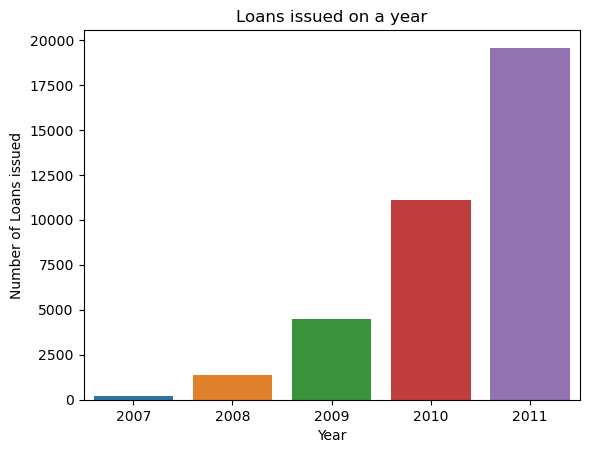

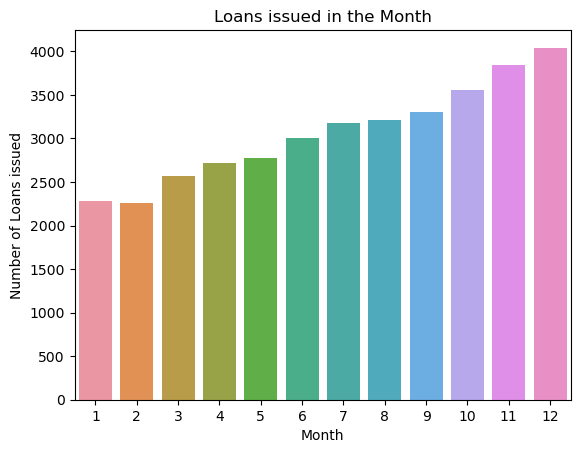

In [36]:

sns.countplot(data=loan, x='issue_year')
plt.xlabel('Year')
plt.ylabel('Number of Loans issued')
plt.title('Loans issued on a year')
plt.show()

sns.countplot(data=loan, x='issue_month')
plt.xlabel('Month')
plt.ylabel('Number of Loans issued')
plt.title('Loans issued in the Month')
plt.show()

- We observe there is a consistent increase of loans issued YOY (Year-on-year). 
- We observe most of the loans are taken during the year 2011.
- Also, most of the loans are issued during the December.

#### Analysing the frequency of loans issued across the States

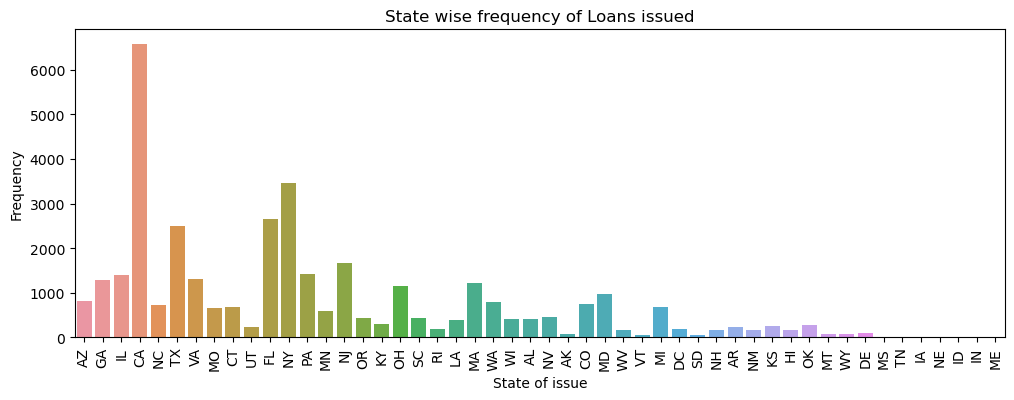

In [37]:
plt.figure(figsize=(12,4))
sns.countplot(data=loan, x='addr_state')
plt.title('State wise frequency of Loans issued')
plt.xlabel('State of issue')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show()

> We observe that the state CA has abnormally high amount of loans issued

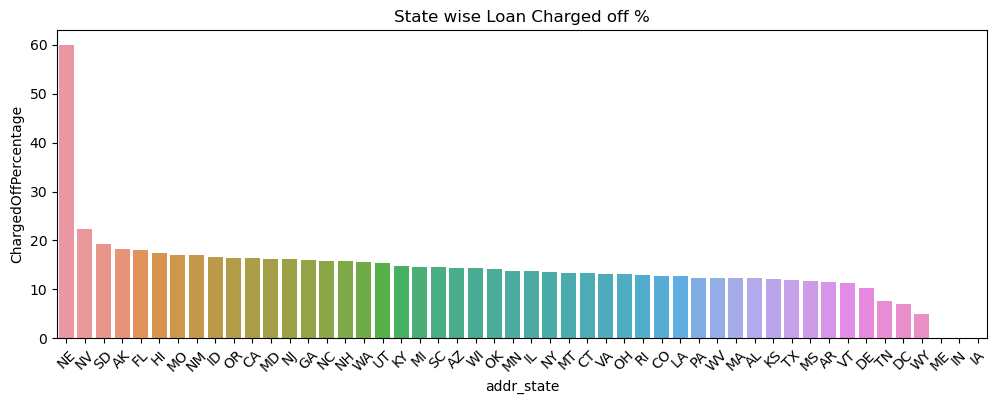

In [38]:
state_wise_loan_status = loan.pivot_table(columns='loan_status', index='addr_state', values='funded_amount', aggfunc='count', fill_value=0)
state_wise_loan_status['ChargedOffPercentage'] = state_wise_loan_status['Charged Off'] *100 /(state_wise_loan_status['Charged Off'] + state_wise_loan_status['Fully Paid'])

state_wise_loan_status = state_wise_loan_status.reset_index()
state_wise_loan_status = state_wise_loan_status.sort_values('ChargedOffPercentage', ascending=False)
plt.figure(figsize=(12,4))
plt.title('State wise Loan Charged off %')
plt.xticks(rotation=45)
sns.barplot(data=state_wise_loan_status, y='ChargedOffPercentage', x='addr_state')
plt.show()

> We Observe that the State: NE has more % of loans charged off

#### Analysing the frequency of loans issued across the grade

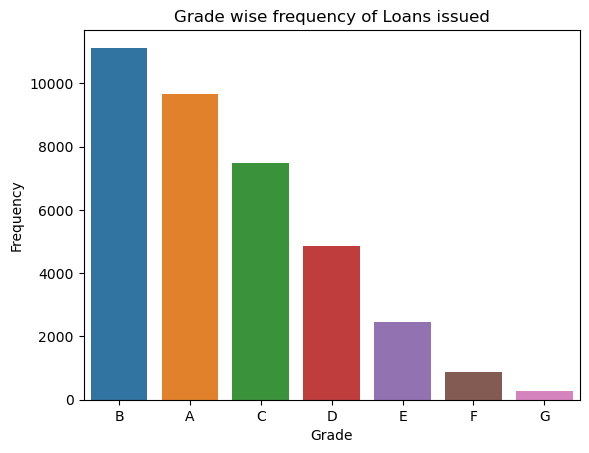

In [39]:
sns.countplot(data=loan, x='grade', order=loan.grade.value_counts().index)
plt.title('Grade wise frequency of Loans issued')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.show()

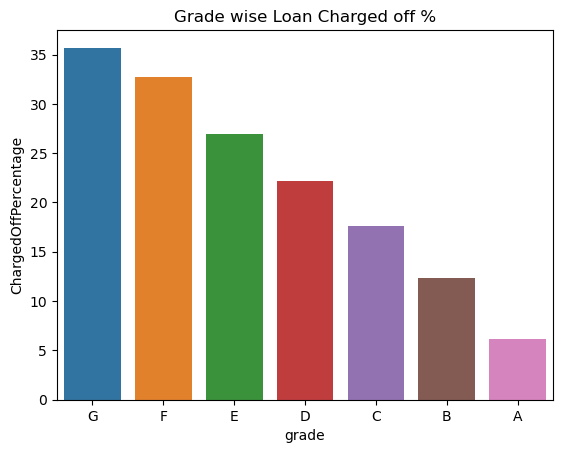

In [40]:
grade_wise_loan_status = loan.pivot_table(columns='loan_status', index='grade', values='funded_amount', aggfunc='count', fill_value=0)
grade_wise_loan_status['ChargedOffPercentage'] = grade_wise_loan_status['Charged Off'] *100 /(grade_wise_loan_status['Charged Off'] + grade_wise_loan_status['Fully Paid'])

grade_wise_loan_status = grade_wise_loan_status.reset_index()
grade_wise_loan_status = grade_wise_loan_status.sort_values('ChargedOffPercentage', ascending=False)
plt.title('Grade wise Loan Charged off %')
sns.barplot(data=grade_wise_loan_status, y='ChargedOffPercentage', x='grade')
plt.show()

> While most of the loans issued are under grade B; More % of loans are charged off under the grade G.

#### Analysing the frequency of loans issued across the sub_grade

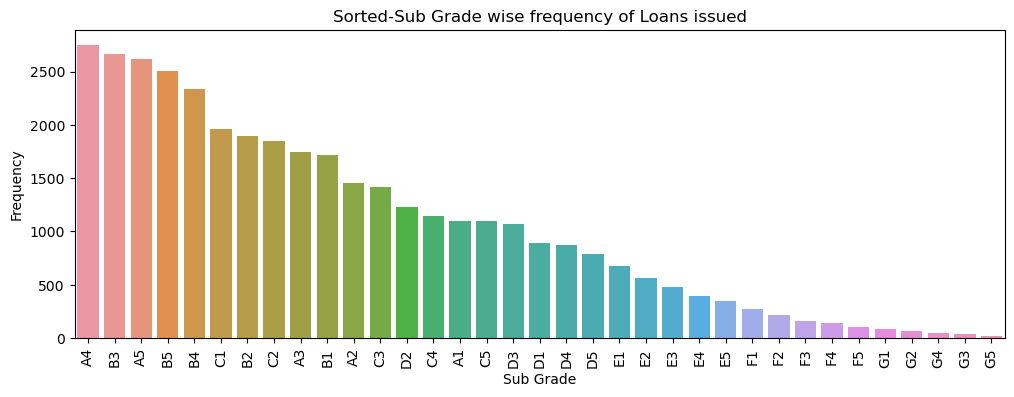

In [41]:
plt.figure(figsize=(12,4))

sns.countplot(data=loan, x='sub_grade', order=loan['sub_grade'].value_counts().index)
plt.title('Sorted-Sub Grade wise frequency of Loans issued')
plt.xticks(rotation=90)
plt.xlabel('Sub Grade')
plt.ylabel('Frequency')
plt.show()

> The Sub-grade A4 has more loans issued

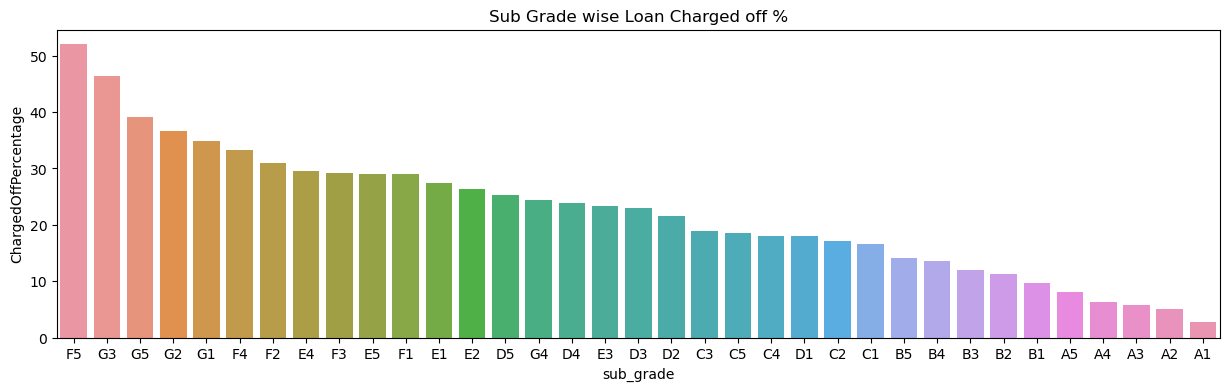

In [42]:
sub_grade_wise_loan_status = loan.pivot_table(columns='loan_status', index='sub_grade', values='funded_amount', aggfunc='count', fill_value=0)
sub_grade_wise_loan_status['ChargedOffPercentage'] = sub_grade_wise_loan_status['Charged Off'] *100 /(sub_grade_wise_loan_status['Charged Off'] + sub_grade_wise_loan_status['Fully Paid'])

sub_grade_wise_loan_status = sub_grade_wise_loan_status.reset_index()
sub_grade_wise_loan_status = sub_grade_wise_loan_status.sort_values('ChargedOffPercentage', ascending=False)

plt.figure(figsize=(15,4))

plt.title('Sub Grade wise Loan Charged off %')
sns.barplot(data=sub_grade_wise_loan_status, y='ChargedOffPercentage', x='sub_grade')

plt.show()

> The sub-Grades F5 has more % of loans Charged Off.
> The Sub-Grades G2, G2, G3, G5 seems to be at the top of the loans being Charged Off.

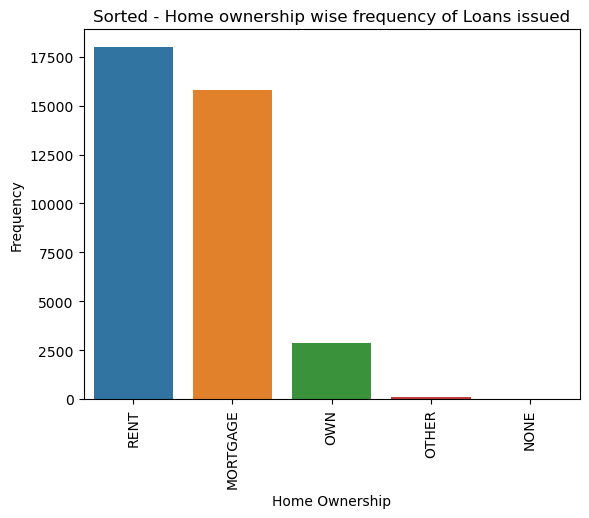

In [43]:

sns.countplot(data=loan, x='home_ownership', order=loan['home_ownership'].value_counts().index)
plt.title('Sorted - Home ownership wise frequency of Loans issued')
plt.xticks(rotation=90)
plt.xlabel('Home Ownership')
plt.ylabel('Frequency')
plt.show()

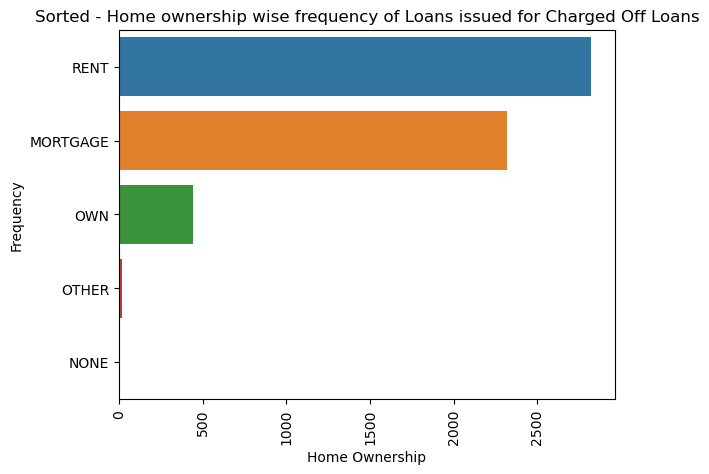

In [44]:

sns.countplot(data=charged_off_loans, y='home_ownership', order=loan['home_ownership'].value_counts().index)
plt.title('Sorted - Home ownership wise frequency of Loans issued for Charged Off Loans')
plt.xticks(rotation=90)
plt.xlabel('Home Ownership')
plt.ylabel('Frequency')
plt.show()

> More loans are given to the people who have home Ownership - Rent. And also, the loans whose home ownership is RENT tend to have their loans Charged Off.

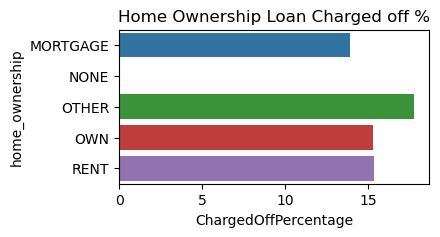

In [45]:
home_ownership_wise_loan_status = loan.pivot_table(columns='loan_status', index='home_ownership', values='funded_amount', aggfunc='count', fill_value=0)
home_ownership_wise_loan_status['ChargedOffPercentage'] = home_ownership_wise_loan_status['Charged Off'] *100 /(home_ownership_wise_loan_status['Charged Off'] + home_ownership_wise_loan_status['Fully Paid'])

home_ownership_wise_loan_status = home_ownership_wise_loan_status.reset_index()

plt.figure(figsize=(4,2))
plt.title('Home Ownership Loan Charged off %')
sns.barplot(data=home_ownership_wise_loan_status, x='ChargedOffPercentage', y='home_ownership')
plt.show()


> We observe the loans with home_ownership mentioned as OTHER have a higher rate of Charged Off.

<AxesSubplot:xlabel='term', ylabel='count'>

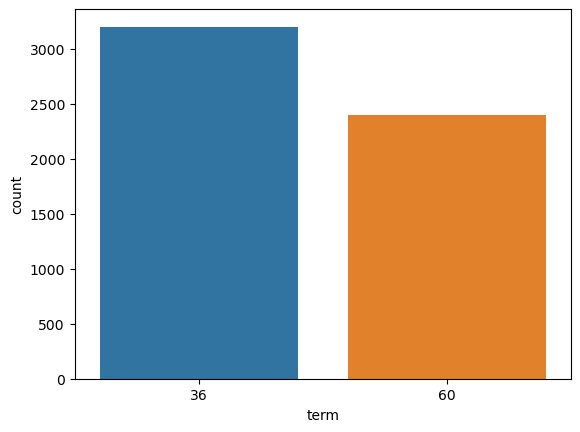

In [46]:
sns.countplot(data=charged_off_loans, x='term')

### Observations from analysis


- Most of the loans funded are with an investor fund between <10000. And loans funded between 3000-6000 have higher chances of Charged Off
- Loans against the purpose Debt_Consolidation top the graph.
- As the loans issued for the purpose of Debt_Consolidation are top, the Charged Off% is also high. Inorder to extract more accurate metric, we can proportionate the Charged Off % of loan_statuses for each of the purpose.
- We observe that the more % of loans are charged off when taken for the purpose 'small_business'
- We see the loans issued to People with employment 10 or more years are more likely to be Charged Off.
- Almost 44% of the loans are not verified. This could be a reason for the defaulters.
- We observe there is a consistent increase of loans issued YOY (Year-on-year).
- We observe most of the loans are taken during the year 2011.
- Also, most of the loans are issued during the December.
- We Observe that the State: NE has more % of loans charged off
- While most of the loans issued are under grade B; More % of loans are charged off under the grade G.
- Ths sub-Grades F5 has more % of loans Charged Off.
- The Sub-Grades G2, G2, G3, G5 seems to be at the top of the loans being Charged Off.
- More loans are given to the people who have home Ownership - Rent. And also, the loans whose home ownership is RENT tend to have their loans Charged Off.
- We observe the loans with home_ownership mentioned as OTHER have a higher rate of Charged Off.

#### Bucketing the continuous data to make it Categorical data

In [47]:
describe_data = charged_off_loans.loc[:,continuous_columns].describe().transpose().sort_values('std', ascending=False)

In [48]:
describe_data

,count,mean,std,min,25%,50%,75%,max
annual_income,5600.0,62487.728936,47862.442574,4080.000000,37000.00,53000.000000,75000.0000,1250000.00
funded_amount_investor,5600.0,10916.903838,7642.875402,0.000121,5000.00,9498.477513,15000.0000,35000.00
installment,5600.0,336.725787,217.329459,22.790000,168.62,294.720000,458.8725,1305.19
total_received_late_fee,5600.0,4.257436,12.733956,0.000000,0.00,0.000000,0.0000,180.20
dti,5600.0,14.005479,6.585432,0.000000,9.05,14.295000,19.2900,29.85
interest_rate,5600.0,13.832711,3.657548,5.420000,11.36,13.610000,16.4000,24.40
emp_length,5600.0,5.290536,3.657226,0.000000,2.00,5.000000,10.0000,10.00
inq_last_6mths,5600.0,1.056786,1.152735,0.000000,0.00,1.000000,2.0000,8.00
public_derogatory_records,5600.0,0.084464,0.284457,0.000000,0.00,0.000000,0.0000,2.00


In [49]:
### Binning all of them to different bins
binned_columns = []
for col in describe_data.index:
    bins = np.linspace(round(describe_data['min'][col]), round(describe_data['max'][col]), 5)
    charged_off_loans['binned_'+col] = pd.cut(charged_off_loans[col], bins=bins, include_lowest=True)
    binned_columns.append('binned_'+col)


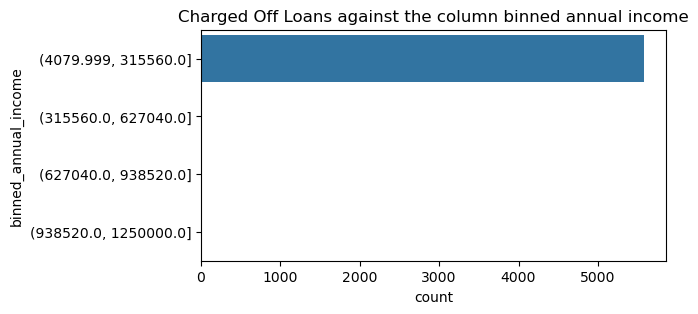

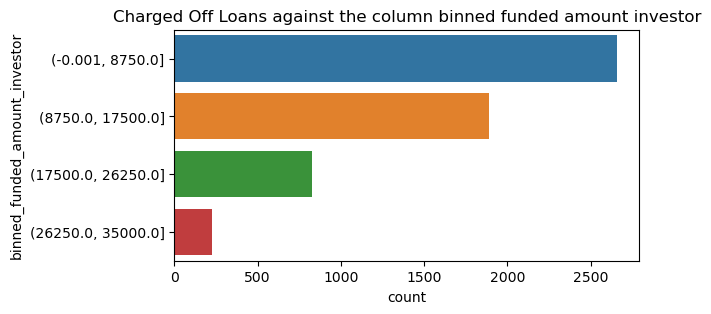

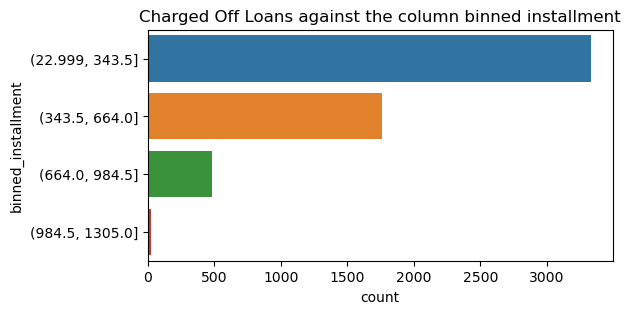

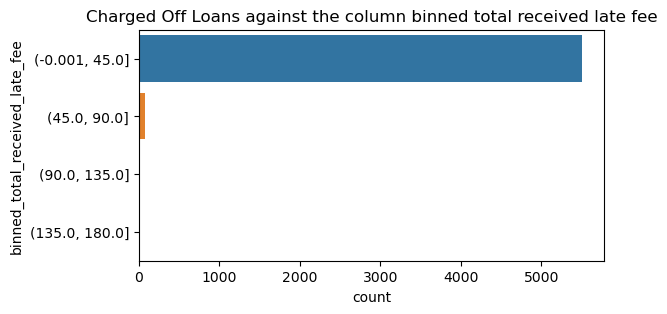

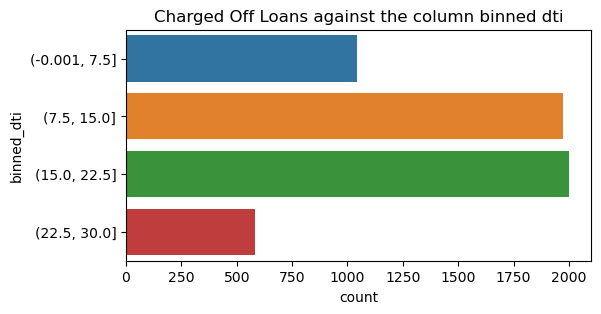

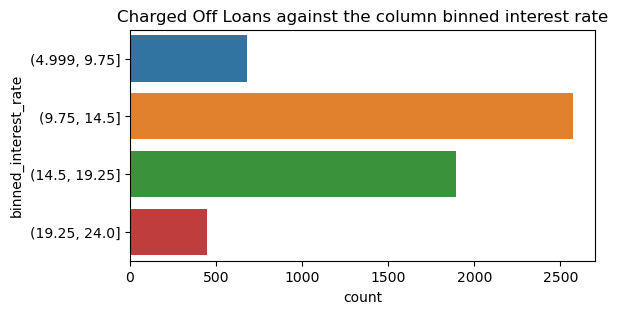

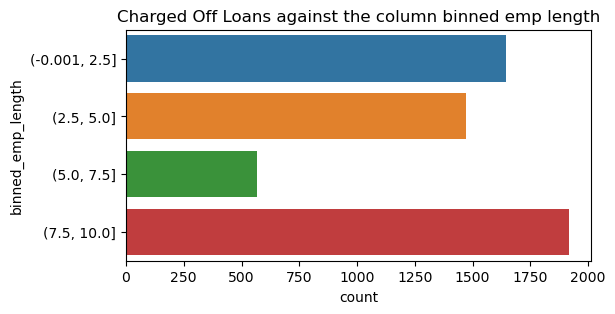

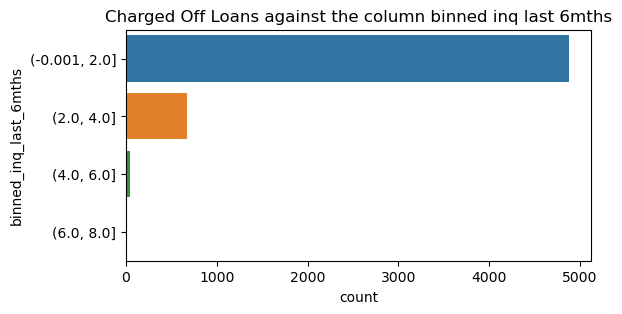

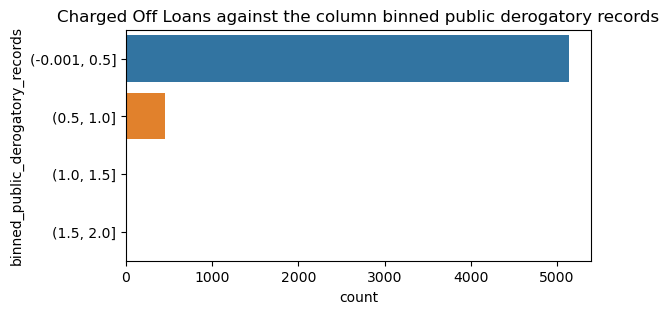

In [50]:
for binned_col in binned_columns:
    plt.figure(figsize=(6,3))
    sns.countplot(data=charged_off_loans, y=binned_col)
    plt.title('Charged Off Loans against the column ' + binned_col.replace('_', ' '))
    plt.show()

- Loans with **Investor funded amount < ~7850** are observed to be Charged Off
- Loans with **Installments in the range of ~23 - 244** are observed to be Charged Off
- Loans with **dti in the range of ~7-22.5** are observed to be Charged Off
- Loans with **Interest Rate in the range of ~ 9.75-14.5** are observed to be Charged Off
- Loans with **1-2 inquiries in last 6 months** are observed to be Charged Off
- Loans with **atleast 1 public derogatory record** are observed to be Charged Off

### Multivariate Analysis

#### Finding correlation across continuous and categorical values for the Charged Off Loans

#### Interest Rate - Purpose

<AxesSubplot:xlabel='interest_rate', ylabel='purpose'>

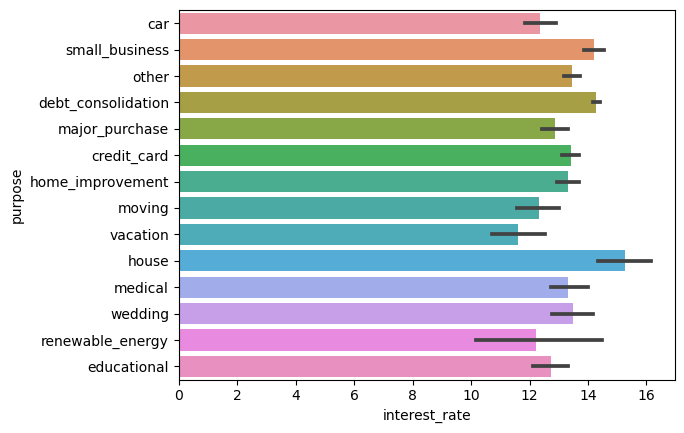

In [51]:
sns.barplot(data=charged_off_loans, y='purpose', x='interest_rate')

> Loans with purpose of House and with higher interest rate are having changes of getting Charged Off

#### Annual Income - emp_length

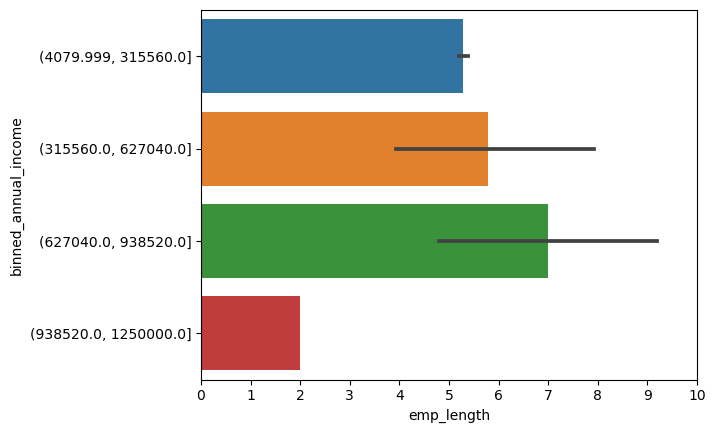

In [52]:
sns.barplot(data=charged_off_loans, x='emp_length', y = 'binned_annual_income')
plt.xticks(ticks=np.arange(0, 11, 1))
plt.show()

> Loans are Charged Off when the employment is 7 years and the annual income is in the range of [627040-938520]

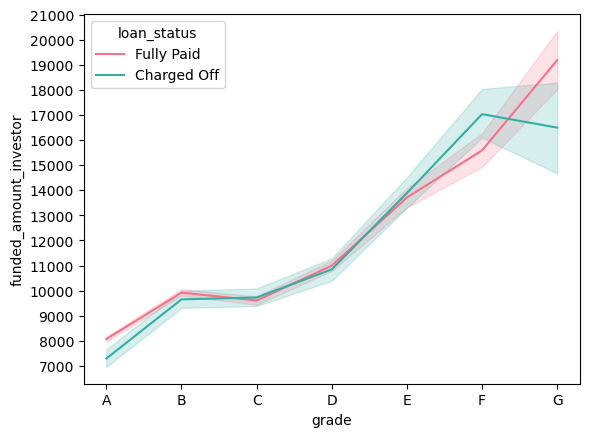

In [53]:
sns.lineplot(data=loan.sort_values('grade'), y='funded_amount_investor', x='grade', sort=True, hue='loan_status', palette='husl')
plt.yticks(ticks=np.arange(7000, 22000, 1000))
plt.show()

> The Loans with Grade F are likely to be Charged Off when the loan_amount is > 16,000. and Grade G with funded_amount_investor < 18000

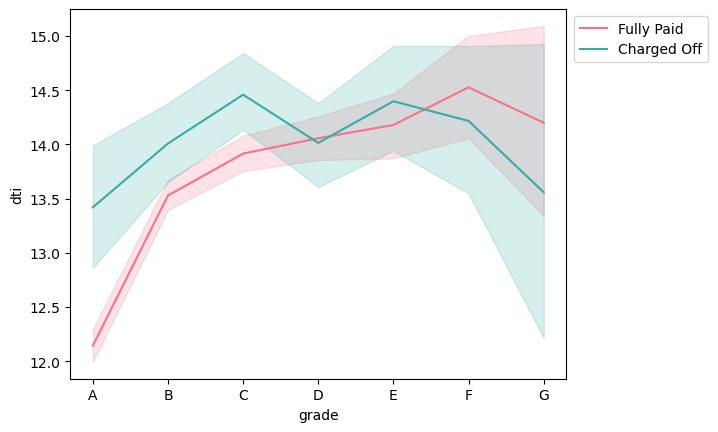

In [54]:
sns.lineplot(data=loan.sort_values('grade'), y='dti', x='grade', sort=True, hue='loan_status', palette='husl')
plt.legend(bbox_to_anchor=(1.3,1))
plt.show()

- Grade C with dti > 14 is likely to be Charged Off. 


- The DTI (Debt to Income ratio) is very vast for Grade Type F & G. 
- This is a potential reason for loans in the Grade F&G are getting Charged Off. 
    - As the person with less dti is likely to find it difficult to pay out his installments. 

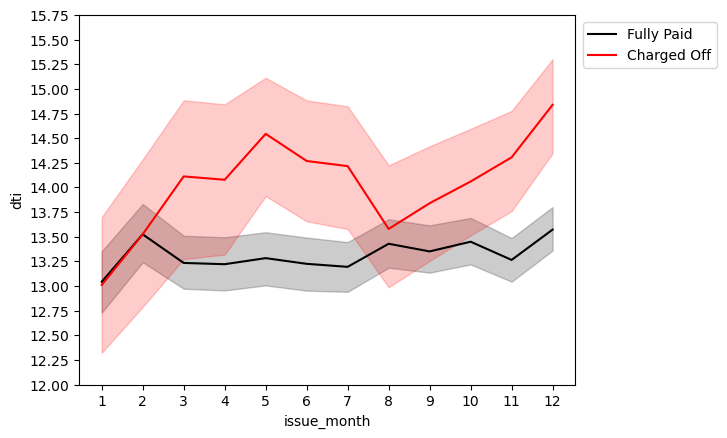

In [55]:
sns.lineplot(data=loan, y='dti', x='issue_month', sort=True, hue='loan_status', palette=['black', 'red'])
plt.xticks(ticks=np.arange(1, 13, 1))
plt.yticks(ticks=np.arange(12, 16, 0.25))
plt.legend(bbox_to_anchor=(1.3,1))
plt.show()

> The Loans issued durng the Months April-July and with the dti > 13.5 have been Charged Off..

> The Loans issued durng the Months Oct-Dec and with the dti > 13.5 have been Charged Off.

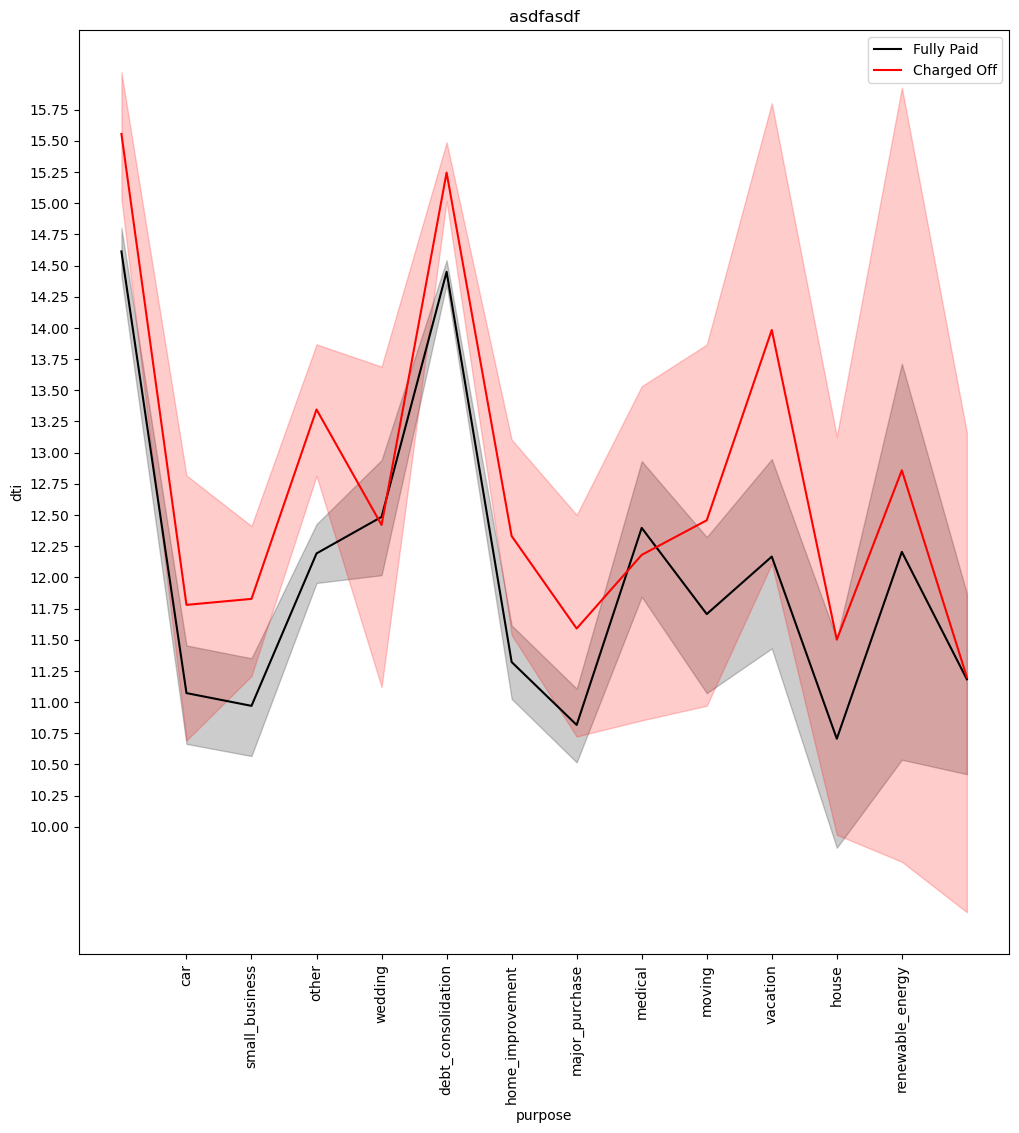

In [56]:
plt.figure(figsize=(12,12))
sns.lineplot(data=loan, y='dti', x='purpose', sort=True, hue='loan_status', palette=['black', 'red'])
plt.xticks(ticks=np.arange(1, 13, 1), rotation=90)
plt.yticks(ticks=np.arange(10, 16, 0.25))
plt.legend(bbox_to_anchor=(1,1))
plt.title('asdfasdf')
plt.show()

- Following loans are Charged Off and can be avoided:
    - Small Businesses with dti > 11.50
    - Vacation with dti > 13.0
    - debt_consolidation with dti > 14.75
    - Major Purchases with dti > 11.25
    - House with dti > 11.50

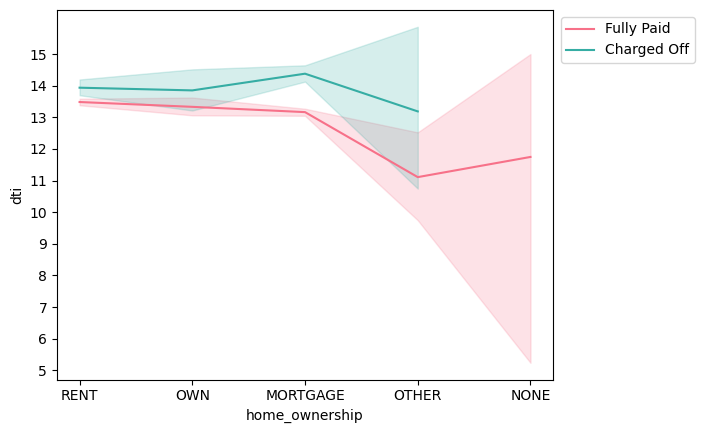

In [57]:
sns.lineplot(data=loan, y='dti', x='home_ownership', sort=True, hue='loan_status', palette='husl')
#plt.xticks(ticks=np.arange(1, 13, 1), rotation=90)
plt.yticks(ticks=np.arange(5, 16, 1))
plt.legend(bbox_to_anchor=(1.3,1))
plt.show()

- Loans with home Ownership as MORTGAGE and DTI>14 are likely to be Charged Off

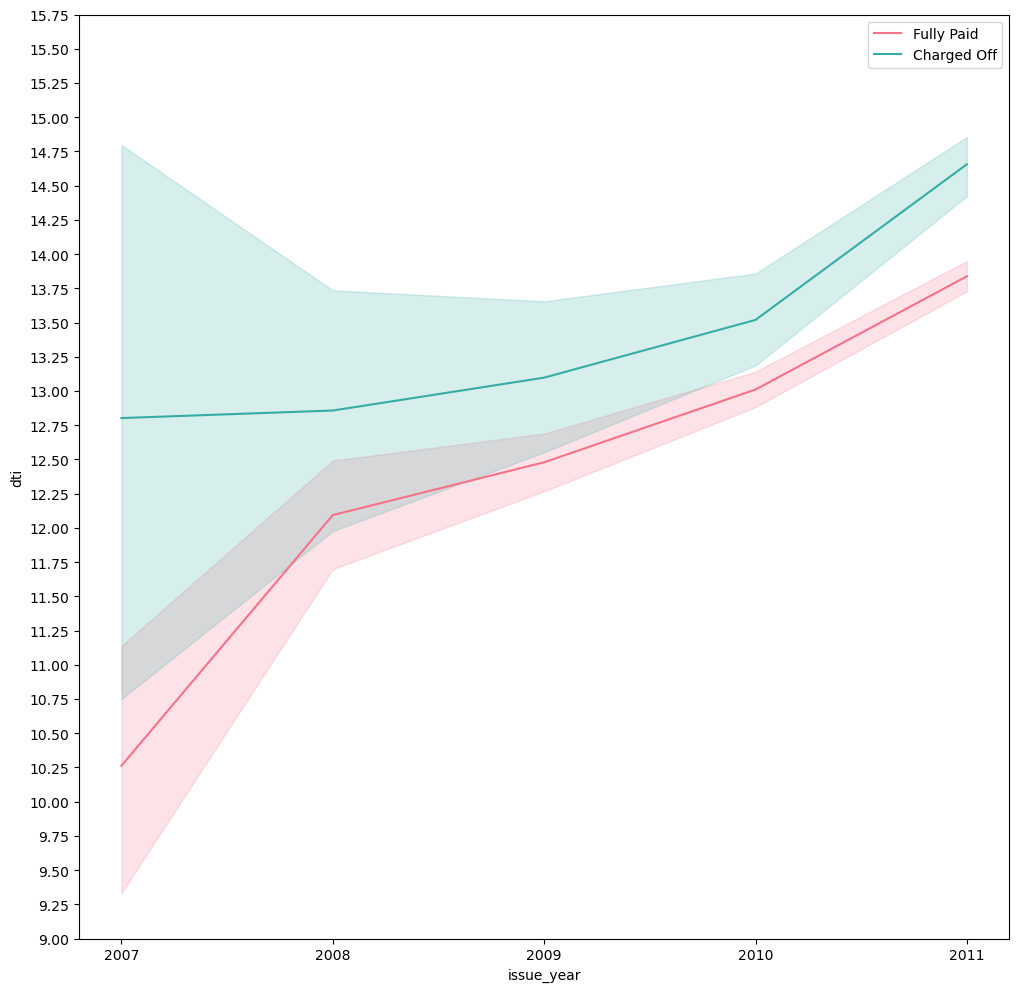

In [58]:
plt.figure(figsize=(12,12))
sns.lineplot(data=loan, y='dti', x='issue_year', sort=True, hue='loan_status', palette='husl')
plt.xticks(ticks=np.arange(2007, 2012, 1))
plt.yticks(ticks=np.arange(9, 16, 0.25))
plt.legend(bbox_to_anchor=(1,1))
plt.show()

- Loans issued during 2010 & 2011 with DTI> 13.25 are likely to be Charged Off.

#### Observations

- Loans with purpose of House and with higher interest rate are having changes of getting Charged Off
- Loans are Charged Off when the **employment is 7 years** and the annual income is in the range of **[627040-938520]**
- The Loans with **Grade F** are likely to be Charged Off when the **loan_amount is > 16,000**. and **Grade G with funded_amount_investor < 18000**

- Loans with **Grade C and having dti > 14** is likely to be Charged Off.
- The DTI (Debt to Income ratio) is very vast for Grade Type F & G.
- This is a potential reason for loans in the Grade F&G are getting Charged Off.
	- As the person with less dti is likely to find it difficult to pay out his installments.

- The Loans issued durng the Months **April-July and with the dti > 13.5** have been Charged Off..
- The Loans issued durng the Months **Oct-Dec and with the dti > 13.5** have been Charged Off.


- Following loans are Charged Off and can be avoided:
	- Small Businesses with dti > 11.50
	- Vacation with dti > 13.0
	- debt_consolidation with dti > 14.75
	- Major Purchases with dti > 11.25
	- House with dti > 11.50
	
- Loans with home Ownership as **MORTGAGE and DTI>14** are likely to be Charged Off
- Loans issued during **2010 & 2011 with DTI> 13.25** are likely to be Charged Off.
